### A. Use AWS Service (S3, Sagemaker)

In [90]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer   

# Define IAM role
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the eu-west-1 region. You will use the 685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


In [91]:
bucket='teamflex'
data1_key = 'Weather.csv'
data2_key = 'fly_dataset.csv'
data_location1 = 's3://{}/{}'.format(bucket, data1_key)
data_location2 = 's3://{}/{}'.format(bucket,data2_key)

df_weather =pd.read_csv(data_location1)
df_flight = pd.read_csv(data_location2)
df_flight.head()

,DATE,MONTH,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,...,ARR_DEL15,ARR_DELAY_GROUP,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,01/02/2013,2,1,9E,20363,N903XJ,3338.0,13930.0,ORD,"Chicago, IL",...,0.0,-1.0,64.0,43.0,265.0,NaN,NaN,NaN,NaN,NaN
1,01/02/2013,2,1,9E,20363,N935XJ,3522.0,13930.0,ORD,"Chicago, IL",...,0.0,-2.0,125.0,99.0,740.0,NaN,NaN,NaN,NaN,NaN
2,01/02/2013,2,1,9E,20363,N910XJ,3552.0,13930.0,ORD,"Chicago, IL",...,1.0,2.0,199.0,177.0,1250.0,6.0,0.0,0.0,0.0,30.0
3,01/02/2013,2,1,9E,20363,N922XJ,3286.0,13930.0,ORD,"Chicago, IL",...,0.0,0.0,81.0,66.0,334.0,NaN,NaN,NaN,NaN,NaN
4,01/02/2013,2,1,9E,20363,N600LR,3310.0,13930.0,ORD,"Chicago, IL",...,0.0,-1.0,97.0,63.0,334.0,NaN,NaN,NaN,NaN,NaN


### B. Data preprocessing

In [92]:
df_weather.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
0,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",01/01/2013,8.50,0.00,0.0,NaN,25,11
1,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",02/01/2013,8.05,0.00,0.0,NaN,30,10
2,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",03/01/2013,11.41,0.00,0.0,NaN,29,18
3,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",04/01/2013,13.20,0.00,0.0,NaN,36,13
4,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",05/01/2013,9.62,0.03,0.4,NaN,39,18



In general, we assume that passenger Aliou must take his flight from AIBD Dakar to Nairobi. In general, Aliou's flight may be delayed if:

*   his plane has to come from another airport (e.g. Orly) and is delayed for any reason.
*    any event prevents the aircraft from taking off in time from the AIBD airport.

Since for this study, we have to take into account the weather data of the departure airport, we are in the second case of example.

In [93]:
df = pd.merge(df_flight,df_weather, how='outer',on=['DATE','DATE'])
#df_flight['DATE']

In [94]:
df.head()

,DATE,MONTH,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,...,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,STATION,NAME,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
0,01/02/2013,2.0,1.0,9E,20363.0,N903XJ,3338.0,13930.0,ORD,"Chicago, IL",...,NaN,NaN,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",12.53,0.02,0.5,NaN,14,0
1,01/02/2013,2.0,1.0,9E,20363.0,N935XJ,3522.0,13930.0,ORD,"Chicago, IL",...,NaN,NaN,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",12.53,0.02,0.5,NaN,14,0
2,01/02/2013,2.0,1.0,9E,20363.0,N910XJ,3552.0,13930.0,ORD,"Chicago, IL",...,0.0,30.0,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",12.53,0.02,0.5,NaN,14,0
3,01/02/2013,2.0,1.0,9E,20363.0,N922XJ,3286.0,13930.0,ORD,"Chicago, IL",...,NaN,NaN,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",12.53,0.02,0.5,NaN,14,0
4,01/02/2013,2.0,1.0,9E,20363.0,N600LR,3310.0,13930.0,ORD,"Chicago, IL",...,NaN,NaN,USW00094846,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",12.53,0.02,0.5,NaN,14,0


### C. Exploratory Data Analysis

In [95]:
df.describe()

,MONTH,DAY_OF_MONTH,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_WAC,DEP_TIME,DEP_DELAY,...,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,AWND,PRCP,SNOW,TAVG,TMAX,TMIN
count,159097.000000,159097.000000,159097.000000,159096.000000,159096.0,159096.0,159096.000000,159096.000000,154597.000000,154597.000000,...,46069.000000,46069.000000,46069.000000,46069.000000,159627.000000,159627.000000,159627.000000,137374.000000,159627.000000,159627.000000
mean,9.164063,14.946291,20179.975198,2932.641952,13930.0,41.0,12670.439414,51.277405,1396.242333,15.300834,...,4.105451,13.897740,0.024094,21.991947,10.404707,0.067567,0.157133,43.686098,48.567661,32.892073
std,3.305285,8.593188,251.917104,1903.163859,0.0,0.0,1561.379047,22.968610,467.400850,37.024646,...,17.286975,23.515728,1.300270,37.065320,3.578639,0.162153,0.586337,18.116703,19.134205,17.690605
min,2.000000,1.000000,19790.000000,3.000000,13930.0,41.0,10135.000000,1.000000,1.000000,-43.000000,...,0.000000,0.000000,0.000000,0.000000,2.010000,0.000000,0.000000,-8.000000,-2.000000,-16.000000
25%,7.000000,8.000000,19977.000000,1222.000000,13930.0,41.0,11278.000000,35.000000,1004.000000,-4.000000,...,0.000000,0.000000,0.000000,0.000000,8.050000,0.000000,0.000000,29.000000,33.000000,20.000000
50%,11.000000,15.000000,20304.000000,2929.000000,13930.0,41.0,12889.000000,45.000000,1402.000000,1.000000,...,0.000000,5.000000,0.000000,4.000000,9.840000,0.000000,0.000000,43.000000,47.000000,32.000000
75%,11.000000,22.000000,20398.000000,4377.750000,13930.0,41.0,14100.000000,71.000000,1810.000000,18.000000,...,0.000000,19.000000,0.000000,30.000000,12.300000,0.040000,0.000000,57.000000,62.000000,45.000000
max,12.000000,31.000000,21171.000000,6530.000000,13930.0,41.0,15919.000000,93.000000,2400.000000,1037.000000,...,865.000000,591.000000,145.000000,705.000000,23.940000,3.540000,9.200000,87.000000,96.000000,77.000000


In [96]:
df.columns

Index(['DATE', 'MONTH', 'DAY_OF_MONTH', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'DEST_WAC',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'TAXI_OUT', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DEL15', 'ARR_DELAY_GROUP', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'STATION', 'NAME', 'AWND',
       'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN'],
      dtype='object')

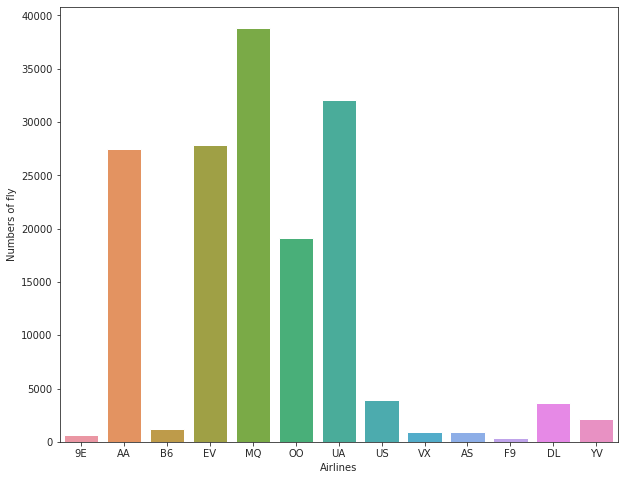

In [97]:
import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize=(10,8))
f1 = sns.countplot('OP_UNIQUE_CARRIER', data=df)
f1.set(ylabel="Numbers of fly", xlabel="Airlines")
plt.show()

**Most famous airlines companies are American Eagle Airlines (MQ), American Airlines (AA), United Airlines (UA)**

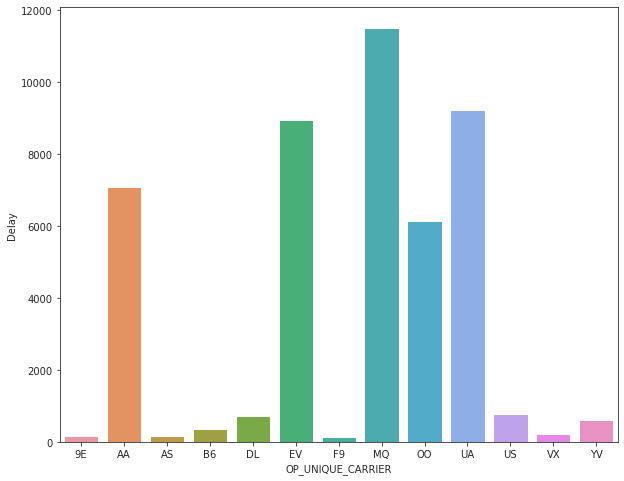

In [98]:
df_delay = df.groupby(["OP_UNIQUE_CARRIER"]).agg(Delay=("ARR_DEL15", "sum")).reset_index()
df_delay
plt.figure(figsize=(10,8))
sns.barplot(x="OP_UNIQUE_CARRIER", y="Delay", data=df_delay)

**We can note that these companies operating many flights have also accumulated enough delays. Two other companies follow the lot (EV, OO). We can note that the companies 9E, AS have a low number of delays.**

### D. Model building

In [99]:
df = df.dropna(how="any")

In [104]:
df.tail()
df.columns

Index(['DATE', 'MONTH', 'DAY_OF_MONTH', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST',
       'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'DEST_WAC',
       'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'TAXI_OUT', 'TAXI_IN', 'ARR_TIME', 'ARR_DELAY',
       'ARR_DEL15', 'ARR_DELAY_GROUP', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'STATION', 'NAME', 'AWND',
       'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN'],
      dtype='object')

In [121]:
X= df[['AIR_TIME',
       'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY',
       'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY','DEP_TIME','ARR_TIME','AWND','PRCP','SNOW','TAVG','OP_CARRIER_AIRLINE_ID']]

In [122]:
X.dropna(how="any")

,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DEP_TIME,ARR_TIME,AWND,PRCP,SNOW,TAVG,OP_CARRIER_AIRLINE_ID
22197,147.0,1197.0,66.0,0.0,0.0,0.0,0.0,1317.0,1458.0,11.41,0.08,0.0,47.0,19805.0
22206,221.0,1744.0,9.0,0.0,15.0,0.0,47.0,1500.0,1638.0,11.41,0.08,0.0,47.0,19805.0
22217,98.0,867.0,0.0,0.0,1.0,0.0,17.0,550.0,828.0,11.41,0.08,0.0,47.0,20409.0
22218,111.0,867.0,32.0,0.0,0.0,0.0,0.0,1441.0,1731.0,11.41,0.08,0.0,47.0,20409.0
22231,96.0,733.0,0.0,0.0,21.0,0.0,0.0,1528.0,1735.0,11.41,0.08,0.0,47.0,19805.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159069,254.0,1846.0,0.0,0.0,53.0,0.0,0.0,1934.0,2208.0,4.92,0.00,0.0,29.0,21171.0
159071,235.0,1744.0,0.0,6.0,3.0,0.0,33.0,1744.0,2017.0,4.92,0.00,0.0,29.0,21171.0
159078,501.0,4243.0,114.0,0.0,0.0,0.0,0.0,1237.0,1723.0,4.92,0.00,0.0,29.0,19977.0
159081,128.0,1005.0,22.0,0.0,0.0,0.0,41.0,1539.0,1918.0,4.92,0.00,0.0,29.0,19977.0


In [123]:
#Rescaling and transforming data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [124]:
Y = df['DEP_DEL15']
#Data splitting and selection and Model fitting
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 )
from sklearn.linear_model import LogisticRegression
logisticRegression = LogisticRegression()
logisticRegression.fit(x_train,y_train)
predictions = logisticRegression.predict(x_test)
score = logisticRegression.score(x_test,y_test)
print(score)

0.9214463840399002


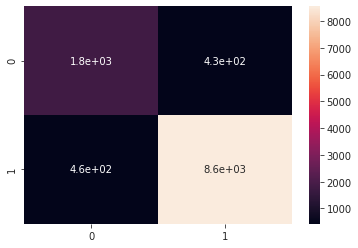

In [125]:
import seaborn as sns
#Matrice de confusion
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(predictions, y_test), annot=True)

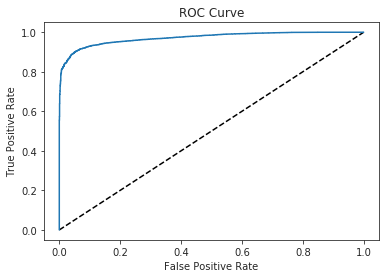

AUC: 0.9714345814217824


In [126]:
###Plotting an ROC curve

# Import necessary modules
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logisticRegression.predict_proba(x_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
###AUC computation

# Import necessary modules
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logisticRegression.predict_proba(x_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

**AUC values are in the range of 0 to 1, in our case AUC =0.97, so most of our predictions are correct.**

### E. Example of the passenger Aliou

In [127]:
##Exemple for test
data = {'AIR_TIME':78,
       'DISTANCE':1500, 
        'CARRIER_DELAY':7, 
        'WEATHER_DELAY':12, 
        'NAS_DELAY':23,
       'SECURITY_DELAY':0, 
        'LATE_AIRCRAFT_DELAY':21,
        'DEP_TIME':1409,
        'ARR_TIME':1923,
        'AWND':6.3,
        'PRCP':18.2,
        'SNOW':2,
        'TAVG':10,
        'OP_CARRIER_AIRLINE_ID':19805}
    
Aliou = pd.DataFrame(data, index=[1])
print(Aliou)
#type(data)

   AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER_DELAY  NAS_DELAY  \
1        78      1500              7             12         23   

   SECURITY_DELAY  LATE_AIRCRAFT_DELAY  DEP_TIME  ARR_TIME  AWND  PRCP  SNOW  \
1               0                   21      1409      1923   6.3  18.2     2   

   TAVG  OP_CARRIER_AIRLINE_ID  
1    10                  19805  


#### Code,Description
"0","No"
"1","Yes"



In [128]:
answer = logisticRegression.predict(Aliou)
print(answer)

[1.]


#### Conclusion: So Aliou's fly will be probably late